# Generating Music with GANs

The following is a pianoroll autoencoder implementation for PowGAN, by Marcos et al. Please run 'PowGAN_train.ipynb' before running this notebook.

This modified notebook aims to build an autoencoder for the Pianoroll dataset. This autoencoder will be salvaged to obtain an efficient latent vector generator to feed to the MuseGAN generator later on. In this version, we only consider the Drums, Bass and Guitar tracks of the pianorolls, in order to reduce the dimension of the problem.

Notebook created by Miguel Marcos, University of Zaragoza, Spain.

## Prerequisites

### Install dependencies

In [ ]:
!pip3 install torch torchmetrics matplotlib tqdm gdown "pypianoroll>=1.0.2"

### Import libraries

In [ ]:
from IPython.display import clear_output
from ipywidgets import interact, IntSlider

import os
import os.path
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import pypianoroll
from pypianoroll import Multitrack, Track
from tqdm import tqdm

2024-12-04 20:23:53.897328: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 20:23:53.940340: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 20:23:53.963462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733340233.988973  455568 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733340233.995802  455568 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regist

## Settings

In [ ]:
#@title Instrument settings
n_tracks = 3  # number of tracks
n_pitches = 72  # number of pitches
lowest_pitch = 24  # MIDI note number of the lowest pitch
n_samples_per_song = 18  # number of samples to extract from each song in the dataset
programs = [0, 25, 33]  # program number for each track
is_drums = [True, False, False]  # drum indicator for each track
track_names = ['Drums', 'Guitar', 'Bass']  # name of each track

assert len(programs) == len(is_drums) and len(programs) == len(track_names), (
    "Lengths of programs, is_drums and track_names must be the same."
)

In [ ]:
#@title Tempo settings
tempo = 100
n_measures = 4  # number of measures per sample
beat_resolution = 4  # temporal resolution of a beat (in timestep)
n_beats_per_measure = 4
measure_resolution = 4 * beat_resolution
tempo_array = np.full((4 * n_measures * n_beats_per_measure * beat_resolution, 1), tempo)

assert 24 % beat_resolution == 0, (
    "beat_resolution must be a factor of 24 (the beat resolution used in "
    "the source dataset)."
)

In [ ]:
#@title Training settings

# Training
batch_size = 32
latent_dim = 256 # Size of the latent vector fed to the generator
n_epochs = 10
eval_interval = 100 # Run metric evaluation every x steps
loss_log_interval = 20 # Log loss to Tensorboard every x steps

# Sampling
save_interval = 500  # interval to run the sampler (in step)

n_samples = 4 # Samples to show when extracting examples. (The plot functions are
              # hardcoded to show 16 measures (4 measures x 4 samples) so you may need
              # to change them if you use other number than 4)

note_thresholds = [0.60828567, 0.55597573, 0.54794814] # Values lower than this are considered silence. Note that this value
                                # directly influences metrics. These three values were obtained via Gaussian Processes
th_tensor = torch.tensor(note_thresholds).view(1,3,1,1)
if torch.cuda.is_available():
  th_tensor = th_tensor.cuda()

## Model definition

 ### Define the decoder

 (Note that the decoder should consist mainly of the GAN's Generator, with its weights loaded.)

In [ ]:
class GeneratorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super(GeneratorBlock,self).__init__()
        self.transconv = torch.nn.ConvTranspose3d(in_dim, out_dim, kernel, stride)
        self.batchnorm = torch.nn.BatchNorm3d(out_dim)
        self.silu = torch.nn.SiLU()

    def forward(self, x):
        x = self.transconv(x)
        x = self.batchnorm(x)
        x = self.silu(x)
        return x

In [ ]:
class OutputBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super(OutputBlock,self).__init__()
        self.transconv = torch.nn.ConvTranspose3d(in_dim, out_dim, kernel, stride)
        self.sig = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.transconv(x)
        x = self.sig(x)
        return x

In [ ]:
class Decoder(torch.nn.Module):
    """A convolutional neural network (CNN) based generator. The generator takes
    as input a latent vector for all tracks and a per-track latent vector,
    then outputs a fake sample."""
    def __init__(self):
        super().__init__()

        # Shared network
        self.transconv0 = GeneratorBlock(latent_dim, 256, (4, 1, 1), (4, 1, 1)) # 4, 1, 1
        self.transconv1 = GeneratorBlock(256, 128, (1, 4, 3), (1, 4, 3)) # 4, 4, 3
        self.transconv2 = GeneratorBlock(128, 64, (1, 2, 2), (1, 2, 2)) # 4, 8, 6

        # Private pitch-time network
        self.pt_transconv3 = torch.nn.ModuleList([
            GeneratorBlock(64, 16, (1, 1, 12), (1, 1, 12)) # 4, 8, 72
            for _ in range(n_tracks)
        ])
        self.pt_transconv4 = torch.nn.ModuleList([
            GeneratorBlock(16, 1, (1, 2, 1), (1, 2, 1)) # 4, 16, 72
            for _ in range(n_tracks)
        ])

        # Private time-pitch network
        self.tp_transconv3 = torch.nn.ModuleList([
            GeneratorBlock(64, 16, (1, 2, 1), (1, 2, 1)) # 4, 16, 6
            for _ in range(n_tracks)
        ])
        self.tp_transconv4 = torch.nn.ModuleList([
            GeneratorBlock(16, 1, (1, 1, 12), (1, 1, 12)) # 4, 16, 72
            for _ in range(n_tracks)
        ])

        # Merge and output
        self.transconv5 = torch.nn.ModuleList([
            OutputBlock(2,1,(1,1,1),(1,1,1)) # 4, 16, 72
            for _ in range(n_tracks)
        ])

    def forward(self, x):
        # Shared network
        x = x.view(-1, latent_dim, 1, 1, 1)
        x = self.transconv0(x)
        x = self.transconv1(x)
        x = self.transconv2(x)
        # Private pitch-time network
        x_pt = [transconv(x) for transconv in self.pt_transconv3]
        x_pt = torch.cat([transconv(x_) for x_, transconv in zip(x_pt, self.pt_transconv4)], 1)
        # Private time-pitch network
        x_tp = [transconv(x) for transconv in self.tp_transconv3]
        x_tp = torch.cat([transconv(x_) for x_, transconv in zip(x_tp, self.tp_transconv4)], 1)
        # Merge and output
        # Probably not the most elegant solution, but it's the only one
        # I could figure out. Tensors and convolutions are really annoying
        x = [torch.cat([torch.unsqueeze(x_pt[:,i],1),
                        torch.unsqueeze(x_tp[:,i],1)],1)
                        for i in range(n_tracks)]

        x = torch.cat([transconv(x_) for x_, transconv in zip(x, self.transconv5)],1)
        x = x.view(-1, n_tracks, n_measures * measure_resolution, n_pitches)
        return x

    def freeze(self):
        self.eval()
        for param in self.parameters():
            param.requires_grad = False

    def unfreeze(self):
        self.train()
        for param in self.parameters():
            param.requires_grad = True

 ### Define the encoder

(Note that the encoder's architecture is almost the same as the GAN's discriminator, except for the head)

In [ ]:
class LayerNorm(torch.nn.Module):
    """An implementation of Layer normalization that does not require size
    information. Copied from https://github.com/pytorch/pytorch/issues/1959."""
    def __init__(self, n_features, eps=1e-5, affine=True):
        super().__init__()
        self.n_features = n_features
        self.affine = affine
        self.eps = eps
        if self.affine:
            self.gamma = torch.nn.Parameter(torch.Tensor(n_features).uniform_())
            self.beta = torch.nn.Parameter(torch.zeros(n_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)
        y = (x - mean) / (std + self.eps)
        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            y = self.gamma.view(*shape) * y + self.beta.view(*shape)
        return y

In [ ]:
class DiscriminatorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.conv = torch.nn.Conv3d(in_dim, out_dim, kernel, stride)
        self.layernorm = LayerNorm(out_dim)
        self.lrelu = torch.nn.LeakyReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.layernorm(x)
        return self.lrelu(x)

In [ ]:
class Encoder(torch.nn.Module):

    def __init__(self):
        super().__init__()

        # Comments next to layers indicate the shape of the output,
        # in the form <M,T,P> (Measure,Time,Pitch)

        # Mirror the private time-pitch network (so now it's pitch-time)
        self.pt_conv0 = torch.nn.ModuleList([
            DiscriminatorBlock(1, 16, (1, 1, 12), (1, 1, 12)) for _ in range(n_tracks) # 4, 16, 6
        ])
        self.pt_conv1 = torch.nn.ModuleList([
            DiscriminatorBlock(16, 64, (1, 2, 1), (1, 2, 1)) for _ in range(n_tracks) # 4, 8, 6
        ])
        # Mirror the private pitch-time network (so now it's time-pitch)
        self.tp_conv0 = torch.nn.ModuleList([
            DiscriminatorBlock(1, 16, (1, 2, 1), (1, 2, 1)) for _ in range(n_tracks) # 4, 8, 72
        ])
        self.tp_conv1 = torch.nn.ModuleList([
            DiscriminatorBlock(16, 64, (1, 1, 12), (1, 1, 12)) for _ in range(n_tracks) # 4, 8, 6
        ])
        # Mirror the shared network
        self.conv2 = DiscriminatorBlock(64 * n_tracks * 2, 128, (1, 2, 2), (1, 2, 2)) # 4, 4, 3
        self.conv3 = DiscriminatorBlock(128, 256, (1, 4, 3), (1, 4, 3)) # 4, 1, 1

        # Chroma stream
        self.chroma_conv0 = DiscriminatorBlock(n_tracks,64,(1,1,12),(1,1,12)) # 4, 4, 1
        self.chroma_conv1 = DiscriminatorBlock(64,128,(1,4,1),(1,4,1)) # 4, 1, 1

        # Onset/Offset stream
        self.onoff_conv0 = DiscriminatorBlock(n_tracks,64,(1,4,1),(1,4,1)) # 4, 4, 1
        self.onoff_conv1 = DiscriminatorBlock(64,128,(1,4,1),(1,4,1)) # 4, 1, 1

        # Merge streams
        self.conv4 = DiscriminatorBlock(512, latent_dim, (2, 1, 1), (1, 1, 1)) # 3, 1, 1
        self.conv5 = DiscriminatorBlock(latent_dim, latent_dim, (3, 1, 1), (3, 1, 1)) # 1, 1, 1

    def forward(self, x):

        # x has shape <B,I,T,P>
        # (Batch, Instrument, Time and Pitch)
        # Instruments are considered channels

        # Extract chroma feature
        chroma = x.view(-1, n_tracks, n_measures, n_beats_per_measure, beat_resolution, n_pitches)
        chroma = torch.sum(chroma,4) # 4, 4, 72
        chroma = chroma.view(-1, n_tracks, n_measures, n_beats_per_measure, n_pitches//12, 12)
        chroma = torch.sum(chroma,4) # 4, 4, 6

        # Extract onset/offset feature
        # Heads-up: PyTorch's padding starts from the last dimension.
        # We want to pad the Time dimension (second to last)
        # (0,0,1,0) means "Don't pad the Pitch dimension, add 1 padding
        # at the top of the Time dimension".
        onoff = torch.nn.functional.pad(x[:,:,:-1],(0,0,1,0))
        onoff = x - onoff
        onoff = onoff.view(-1, n_tracks, n_measures, measure_resolution, n_pitches)
        onoff = torch.sum(onoff,4,keepdim=True) # 4, 16, 1

        # Compute the private instrument networks
        x = x.view(-1, n_tracks, 1, n_measures, measure_resolution, n_pitches)
        # Pitch-time
        x_pt = [conv(x[:,i]) for i, conv in enumerate(self.pt_conv0)]
        x_pt = torch.cat([conv(x_) for x_, conv in zip(x_pt, self.pt_conv1)], 1)
        # Time-pitch
        x_tp = [conv(x[:,i]) for i, conv in enumerate(self.tp_conv0)]
        x_tp = torch.cat([conv(x_) for x_, conv in zip(x_tp, self.tp_conv1)], 1)
        # Shared network
        x = torch.cat([x_pt,x_tp],1)
        x = self.conv2(x)
        x = self.conv3(x)

        # Chroma stream
        c = self.chroma_conv0(chroma)
        c = self.chroma_conv1(c)

        # Osset/offset stream
        o = self.onoff_conv0(onoff)
        o = self.onoff_conv1(o)

        # Merge streams
        x = torch.cat([x,c,o],1)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(-1, latent_dim)

        return x

    def load_critic_weights(self,state_dict,verb=True):
        # Special weight loading function
        # Since we chopped the model's head off,
        # loading the whole state dictionary won't work,
        # it will ask for the 'dense1' layer
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                continue
            if verb:
                print(name)
            own_state[name].copy_(param)

    def freeze(self):
        self.eval()
        for param in self.parameters():
            param.requires_grad = False

    def unfreeze(self):
        self.train()
        for param in self.parameters():
            param.requires_grad = True

### Define the VAE

In [ ]:
class LinearLReLUBlock(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = torch.nn.Linear(input_dim,output_dim)
        self.batchnorm = torch.nn.BatchNorm1d(output_dim)
        self.lrelu = torch.nn.LeakyReLU()

    def forward(self,x):
        x = self.lrelu(self.batchnorm(self.dense(x)))
        return x

In [ ]:
class VarAutoencoder(torch.nn.Module):
    def __init__(self,encoder,decoder):
        super().__init__()
        self.enc = encoder
        self.dec = decoder

        self.dense_enc1 =  LinearLReLUBlock(latent_dim,128)
        self.dense_enc2 =  LinearLReLUBlock(128,64)
        self.dense_enc3 =  LinearLReLUBlock(64,32)
        self.dense_enc4 =  LinearLReLUBlock(32,10)
        self.mus = torch.nn.Linear(10,10)
        self.sigmas = torch.nn.Linear(10,10)
        self.dense_dec1 =  LinearLReLUBlock(10,32)
        self.dense_dec2 =  LinearLReLUBlock(32,64)
        self.dense_dec3 =  LinearLReLUBlock(64,128)
        self.dense_dec4 =  torch.nn.Linear(128,latent_dim)

        """
        self.dense_enc = LinearLReLUBlock(latent_dim,latent_dim)
        self.mus = torch.nn.Linear(latent_dim,latent_dim)
        self.sigmas = torch.nn.Linear(latent_dim,latent_dim)
        self.dense_dec = LinearLReLUBlock(latent_dim,latent_dim)
        """

        self.N = torch.distributions.Normal(0,1)
        if torch.cuda.is_available():
          self.N.loc = self.N.loc.cuda()
          self.N.scale = self.N.scale.cuda()

        self.kl = 0

    def forward(self, x):

        #Encode the input
        x = self.enc(x)
        #Dimensionality reduction

        x = self.dense_enc1(x)
        x = self.dense_enc2(x)
        x = self.dense_enc3(x)
        x = self.dense_enc4(x)
        """
        x = self.dense_enc(x)
        """

        #Extract the distributions
        mu = self.mus(x)
        mu2 = torch.pow(mu,2)
        sigma = self.sigmas(x)
        sigma2 = torch.pow(sigma,2)
        #Sanity check, in case some wild zero appears in sigma2
        sigma2+=1e-6
        #Sample the distributions
        z = mu + sigma*self.N.sample(mu.shape)
        #Compute KL divergence
        self.kl = (mu2 + sigma2 - torch.log(sigma2) - 0.5).mean()

        # Dimensionality augmentation to match the decoder input

        x = self.dense_dec1(z)
        x = self.dense_dec2(x)
        x = self.dense_dec3(x)
        x = self.dense_dec4(x)
        """
        x = self.dense_dec(x)
        """
        #Decode the sampled latent values
        x = self.dec(x)
        #Smooth thresholding
        x = torch.sigmoid(10*(x-th_tensor))

        return x

    def freeze(self):
        self.enc.freeze()
        self.dec.freeze()

    def freeze_enc(self):
        self.enc.freeze()

    def freeze_dec(self):
        self.dec.freeze()

    def unfreeze(self):
        self.enc.unfreeze()
        self.dec.unfreeze()

    def unfreeze_enc(self):
        self.enc.unfreeze()

    def unfreeze_dec(self):
        self.dec.unfreeze()

    def get_encoding(self, x):

      return self.dense_enc1(self.enc(x))

    def sample_latent_space(self,x):

      mu = self.mus(x)
      sigma = self.sigmas(x)
      z = mu + sigma*self.N.sample(mu.shape)

      return z

    def get_decoded_latent_space(self,x):

      return self.dense_dec1(x)


## Model instantiation

In [ ]:
# Load the GAN generator and the weights
decoder = Decoder()
gen_checkpoint_path = "powgan_gen.pt"
if torch.cuda.is_available():
  device = torch.device('cuda')
  gen_checkpoint = torch.load(gen_checkpoint_path)
else:
  device = torch.device('cpu')
  gen_checkpoint = torch.load(gen_checkpoint_path, map_location=device)
decoder.load_state_dict(gen_checkpoint['model_state_dict'])

/tmp/ipykernel_455568/2574084778.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_checkpoint = torch.load(gen_checkpoint_path)


<All keys matched successfully>

In [ ]:
encoder = Encoder()
disc_checkpoint_path = "powgan_disc.pt"
if torch.cuda.is_available():
  device = torch.device('cuda')
  disc_checkpoint = torch.load(disc_checkpoint_path)
else:
  device = torch.device('cpu')
  disc_checkpoint = torch.load(disc_checkpoint_path, map_location=device)
encoder.load_critic_weights(disc_checkpoint['model_state_dict'],verb=False)

/tmp/ipykernel_455568/58673917.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  disc_checkpoint = torch.load(disc_checkpoint_path)


In [ ]:
# Create networks
autoencoder = VarAutoencoder(encoder,decoder)

# Create optimizer
a_optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=0.001)

# Transfer the neural nets and samples to GPU
if torch.cuda.is_available():
    encoder = encoder.cuda()
    decoder = decoder.cuda()
    autoencoder = autoencoder.cuda()

# Initialize step
epoch = 0
step = 0
autoencoder.freeze()

## Metric extraction functions


In [ ]:
#@title Used Pitch Classes (UPC)
def used_pitch_classes(sample_tensor):
  """
  Samples are supposed to be a tensor of shape [n,i,t,p] where
  · n is the number of samples
  · i is the number of instruments (tracks)
  · t is the timestep resolution (beat_resolution*beats_per_measure*measures)
  · p is the pitch dimension
  """
  s = sample_tensor.size()
  sample_bars = sample_tensor.view(s[0],s[1],s[2]//measure_resolution,measure_resolution,s[3]//12,12)
  sample_bars = sample_bars[:,1:] # No drums
  s = sample_bars.size()

  """
  sample_bars is now of shape [n,i,m,b,s,p] where
  · m is the number of measures per sample
  · b is the timesteps in a measure (beat_resolution*beats_per_measure)
  · s is the scale of the pitch
  """

  # Sum over scales -> [n,i,m,b,p]
  scaled_pitch_hist = torch.sum(sample_bars,dim=4)
  # Sum all pitch appearances over the beats of each measure -> [n,i,m,p]
  pitch_hist = torch.sum(scaled_pitch_hist,dim=3)
  # If a pitch appears atleast once in a bar, it is counted -> [n,i,m,p]
  # Then sum -> [n,i,m]
  pitches_per_bar = torch.sum(torch.nn.functional.sigmoid((pitch_hist-0.7)*15),dim=3)
  # Average over alls measure of each sample
  avg_p_per_track = torch.mean(pitches_per_bar,dim=2)

  return avg_p_per_track

In [ ]:
#@title Tonal Distance (TD)
r1=1.0 ; r2=1.0 ; r3 = 0.5
tm = np.empty((6, 12), dtype=np.float32)
tm[0, :] = r1*np.sin(np.arange(12)*(7./6.)*np.pi)
tm[1, :] = r1*np.cos(np.arange(12)*(7./6.)*np.pi)
tm[2, :] = r2*np.sin(np.arange(12)*(3./2.)*np.pi)
tm[3, :] = r2*np.cos(np.arange(12)*(3./2.)*np.pi)
tm[4, :] = r3*np.sin(np.arange(12)*(2./3.)*np.pi)
tm[5, :] = r3*np.cos(np.arange(12)*(2./3.)*np.pi)
tm = torch.tensor(tm)
if torch.cuda.is_available():
  tm = tm.cuda()

def tonal_dist(beat_chroma1, beat_chroma2):
  beat_chroma1 = beat_chroma1 / torch.sum(beat_chroma1)
  c1 = torch.matmul(tm, beat_chroma1)
  beat_chroma2 = beat_chroma2 / torch.sum(beat_chroma2)
  c2 = torch.matmul(tm, beat_chroma2)
  return torch.linalg.norm(c1-c2)

def bar_tonal_distance(chroma1, chroma2):
  chr1 = torch.sum(chroma1, axis=0)
  chr2 = torch.sum(chroma2, axis=0)
  return tonal_dist(chr1,chr2)

def tonal_distance(samples):
  """
  Samples are supposed to be a tensor of shape [n,i,t,p] where
  · n is the number of samples
  · i is the number of instruments (tracks)
  · t is the timestep resolution (beat_resolution*beats_per_measure*measures)
  · p is the pitch dimension
  """

  s = samples.shape
  bars = samples.view((s[0],s[1],s[2]//measure_resolution,measure_resolution,s[3]))
  bars = bars [:,1:] # No drums
  s = bars.shape

  """
  bars is now of shape [n,i,m,b,p] where
  · m is the number of measures per sample
  · b is the timesteps in a measure (beat_resolution*beats_per_measure)
  """

  scores = torch.zeros((s[0],s[2]))
  total_bars = torch.ones(s[0])*s[2]
  if torch.cuda.is_available():
    scores = scores.cuda()
    total_bars = total_bars.cuda()


  chromas = bars.view(s[0],s[1],s[2],s[3],12,-1).sum(dim=5)
  non_empty_chromas = 1.0 - torch.exp(torch.sum(chromas,dim=(3,4))*(-15)) # Differentiable "==0"
  td_doable = non_empty_chromas[:,0]*non_empty_chromas[:,1]
  good_bars = torch.sum(td_doable,dim=1)

  for i in range(s[0]):
    for j in range(s[2]):
      if td_doable[i,j]:
        scores[i][j] = bar_tonal_distance(chromas[i,0,j],chromas[i,1,j])

  good_scores = scores * (good_bars/(good_bars+1e-6)).view(good_bars.shape[0],1) # Good_bars == 0 ? 0 : scores

  return torch.sum(good_scores,dim=1)/(good_bars+1e-6)

In [ ]:
#@title Silence Ratio (SR)

def silence_ratio(samples):

  return 1.0 - torch.mean(samples,dim=(2,3))

## Create dataset and data loader

In [ ]:
np.random.seed(42)
data = []
with torch.no_grad():
  for _ in range(2000):
    x = torch.tensor(np.random.randn(batch_size,latent_dim)).float()
    if torch.cuda.is_available():
      x=x.cuda()
    data.append(torch.nn.functional.sigmoid((decoder(x)-th_tensor)*10))
  data = torch.vstack(data)
  print(data.shape)

torch.Size([64000, 3, 64, 72])


In [ ]:
train_data_loader = torch.utils.data.DataLoader(
    data[:9*len(data)//10], batch_size=batch_size, drop_last=True, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(
    data[9*len(data)//10:], batch_size=batch_size, drop_last=True, shuffle=True)

In [ ]:
metrics = []

for x in train_data_loader:
    upcs = used_pitch_classes(x)
    tds = tonal_distance(x).view(-1,1)
    srs = silence_ratio(x).view(-1,3)
    mfs = torch.hstack([upcs,tds,srs])
    metrics.append(mfs)

dataset_mfs = torch.vstack(metrics)
dataset_avg_mfs = torch.mean(dataset_mfs,dim=0)
dataset_std_mfs = torch.std(dataset_mfs,dim=0)
print(dataset_avg_mfs)
print(dataset_std_mfs)

tensor([3.4639, 2.3375, 0.9135, 0.9825, 0.9647, 0.9829], device='cuda:0')
tensor([1.9279, 0.9184, 0.2465, 0.0085, 0.0244, 0.0049], device='cuda:0')


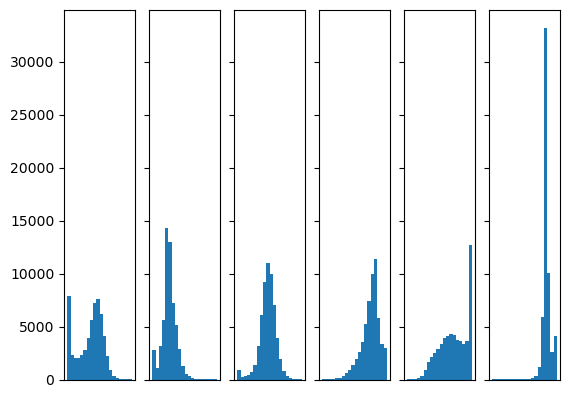

In [ ]:
fig, axs = plt.subplots(1,len(dataset_avg_mfs),sharey=True)
for i in range(len(dataset_avg_mfs)):
  axs[i].hist(dataset_mfs[:,i].cpu().detach().numpy(),bins=20)
  axs[i].get_xaxis().set_visible(False)
plt.plot()
plt.show()

## Training functions

In [ ]:
class AssymetricLoss(torch.nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
      super(AssymetricLoss, self).__init__()

      self.gamma_neg = gamma_neg
      self.gamma_pos = gamma_pos
      self.clip = clip
      self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
      self.eps = eps

      # For normalizaton
      self.zero = 0
      self.one = 1

    def forward(self, x, y):
      """
      Parameters
      ----------
      x: input logits
      y: targets
      """

      # Calculating probabilities
      x_sigmoid = torch.sigmoid(x)
      xs_pos = x_sigmoid
      xs_neg = 1 - x_sigmoid

      # Asymmetric Clipping
      if self.clip is not None and self.clip > 0:
          xs_neg = (xs_neg + self.clip).clamp(max=1)

      # Basic CE calculation
      los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
      los_neg = (1-y) * torch.log(xs_neg.clamp(min=self.eps))
      loss = los_pos + los_neg

      # Asymmetric Focusing
      if self.gamma_neg > 0 or self.gamma_pos > 0:
        if self.disable_torch_grad_focal_loss:
          torch.set_grad_enabled(False)
        pt0 = xs_pos * y
        pt1 = xs_neg * (1 - y) # pt = p if t > 0 else 1 - p
        pt = pt0 + pt1
        one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
        one_sided_w = torch.pow(1 - pt, one_sided_gamma)
        if self.disable_torch_grad_focal_loss:
          torch.set_grad_enabled(True)
        loss *= one_sided_w

      return (-loss.sum([1,2,3]).mean() - self.zero)/(self.one-self.zero)

In [ ]:
assym_loss = AssymetricLoss(gamma_neg=16,gamma_pos=4,disable_torch_grad_focal_loss=True)

In [ ]:
losses = torch.zeros(8)

with torch.no_grad():

    for loss_sample in train_data_loader:
        loss_sample = loss_sample.cpu().detach()
        # Loss of a perfect batch
        losses[0] += assym_loss(loss_sample,loss_sample).item()
        # Loss of a batch with a wrong note in each sample (not much difference)
        loss_sample_one_error = torch.clone(loss_sample)
        loss_sample_one_error[:,0,0,0] = 1 - loss_sample_one_error[:,0,0,0]
        losses[1] += assym_loss(loss_sample_one_error,loss_sample).item()
        # Loss of a good batch, with some uncertainty (0's are 0.1 and 1's are 0.9)
        loss_sample_unsure = torch.clone(loss_sample)
        loss_sample_unsure[loss_sample_unsure<0.5] = 0.1
        loss_sample_unsure[loss_sample_unsure>0.5] = 0.9
        losses[2] += assym_loss(loss_sample_unsure,loss_sample).item()
        # Loss of a good batch, with much uncertainty (0's are 0.4 and 1's are 0.6)
        loss_sample_unsure[loss_sample_unsure<0.5] = 0.4
        loss_sample_unsure[loss_sample_unsure>0.5] = 0.6
        losses[3] += assym_loss(loss_sample_unsure,loss_sample).item()
        # Loss of a random batch sampled uniformly in [0,1)
        losses[4] += assym_loss(torch.rand(loss_sample.shape),loss_sample).item()
        # Loss of a fully silent batch
        losses[5] += assym_loss(torch.zeros(loss_sample.shape),loss_sample).item()
        # Loss of a batch with all notes playing
        losses[6] += assym_loss(torch.ones(loss_sample.shape),loss_sample).item()
        # Loss of a negative batch (all silences are notes, and vice versa)
        losses[7] += assym_loss(1-loss_sample,loss_sample).item()

losses /= len(train_data_loader)

assym_loss.zero = losses[0].item()
assym_loss.one = losses[5].item()

losses -= losses[0].item()
losses /= losses[5].item()

print("Perfect:",losses[0].item())
print("One wrong note:",losses[1].item())
print("Low uncertainty:",losses[2].item())
print("High uncertainty:",losses[3].item())
print("Random:",losses[4].item())
print("Full silence:",losses[5].item())
print("Full fanfare:",losses[6].item())
print("Negative batch:",losses[7].item())

Perfect: 0.0
One wrong note: 0.0002554790407884866
Low uncertainty: 0.01847727596759796
High uncertainty: 0.1992015391588211
Random: 0.8910901546478271
Full silence: 1.0
Full fanfare: 3.4707682132720947
Negative batch: 4.359457969665527


In [ ]:
print(assym_loss.zero,assym_loss.one)

0.44715172052383423 9.786834716796875


### Training step

In [ ]:
def compare_mf(dec_samples,samples):
    upc = used_pitch_classes(samples)
    td = tonal_distance(samples).view(-1,1)
    dd = silence_ratio(samples).view(-1,3)
    mfs = torch.hstack([upc,td,dd])
    n_mfs = (mfs - dataset_avg_mfs) / dataset_std_mfs

    dec_upc = used_pitch_classes(dec_samples)
    dec_td = tonal_distance(dec_samples).view(-1,1)
    dec_dd = silence_ratio(dec_samples).view(-1,3)
    dec_mfs = torch.hstack([dec_upc,dec_td,dec_dd])
    n_dec_mfs = (dec_mfs - dataset_avg_mfs) / dataset_std_mfs

    loss = torch.nn.functional.mse_loss(n_dec_mfs,n_mfs,reduction='mean')

    return loss

In [ ]:
def train_one_step(optimizer, samples, kl_beta):
    """Train the networks for one step."""

    # Transfer data to GPU
    if torch.cuda.is_available():
        samples = samples.cuda()

    # === Train the autoencoder ===
    # Reset cached gradients to zero
    optimizer.zero_grad()

    # Get encoder outputs for the real samples
    dec_samples = autoencoder(samples)

    # Get features for both decoded and real samples

    # Compute the loss function
    kl_loss = kl_beta*autoencoder.kl

    asl_loss = assym_loss(dec_samples,samples)
    mf_loss = compare_mf(dec_samples,samples)

    # Backpropagate the gradients
    loss = asl_loss + kl_loss
    #loss = mf_loss + kl_loss

    loss.backward()

    # Update the weights
    optimizer.step()

    return asl_loss, mf_loss, autoencoder.kl

## Plotting Functions

In [ ]:
def clip_samples(samples,thresholds):
    samples = torch.transpose(samples,0,1)
    for i in range(n_tracks):
        samples[i,samples[i]<thresholds[i]]=0.0
    samples = torch.transpose(samples,0,1)
    return samples

In [ ]:
def samples_to_multitrack(samples):

  samples = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
  tracks = []
  for idx, (program, is_drum, track_name) in enumerate(
      zip(programs, is_drums, track_names)
  ):
      pianoroll = np.pad(
          samples[idx] > 0.1,
          ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
      )
      tracks.append(
          Track(
              name=track_name,
              program=program,
              is_drum=is_drum,
              pianoroll=pianoroll
          )
      )
  m = Multitrack(
      tracks=tracks,
      tempo=tempo_array,
      resolution=beat_resolution
  )

  return m

In [ ]:
def plot_multitrack(m):
  axs = m.plot()
  plt.gcf().set_size_inches((16, 8))
  for ax in axs:
      for x in range(
          measure_resolution,
          4 * measure_resolution * n_measures,
          measure_resolution
      ):
          if x % (measure_resolution * 4) == 0:
              ax.axvline(x - 0.5, color='k')
          else:
              ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
  plt.show()


## Defining Checkpoint

In [ ]:
def save_checkpoint(aenc_path,loss):

    torch.save({
        'epoch':step,
        'model_state_dict':autoencoder.state_dict(),
        'optimizer_state_dict':a_optimizer.state_dict(),
        'loss':loss
    },aenc_path)


In [ ]:
#@title Basic checkpoint (every x steps)
# Checkpoint to save
checkpoint_path = "autoencoder_asl.pt"
#checkpoint_path = "autoencoder_mf.pt"

## Training

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

  0%|                                                                                                             | 0/18000 [00:55<?, ?it/s]
(asl= 0.7529, mf= 1.9010, kl_loss= 2.9672, kl_beta= 0.0025):  10%|███▋                                 | 1799/18000 [01:25<06:40, 40.45it/s]

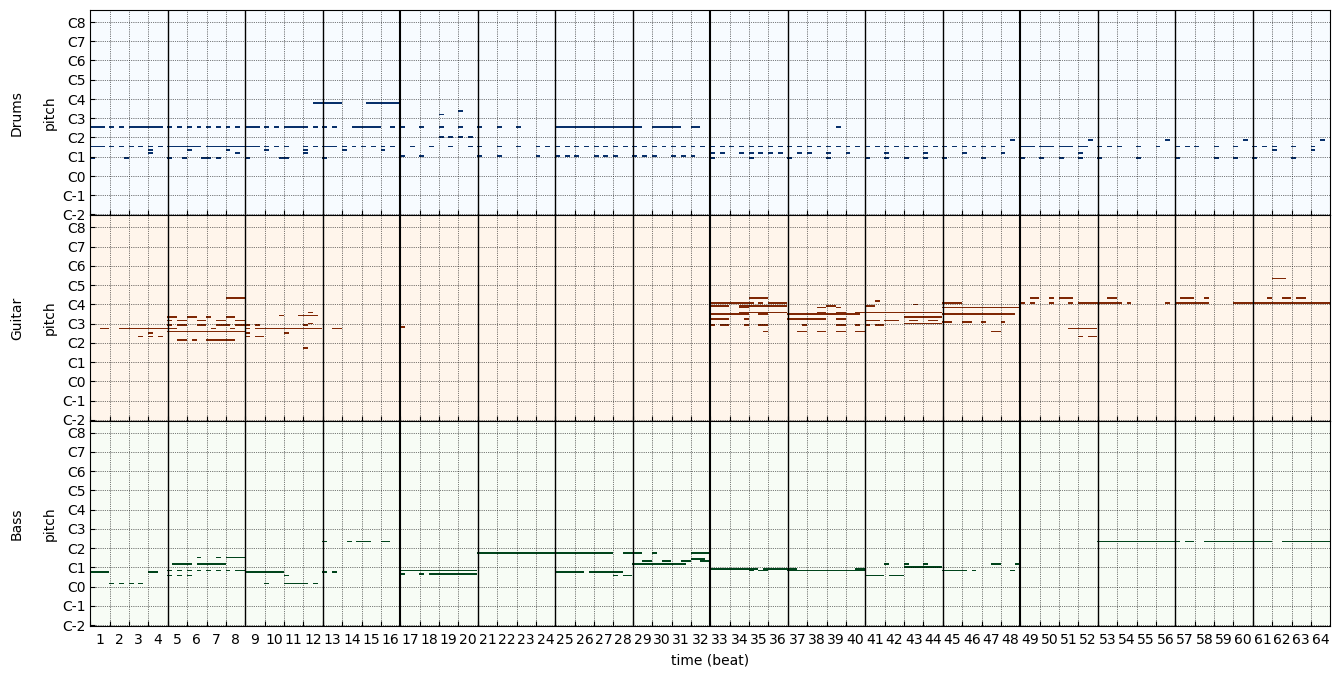

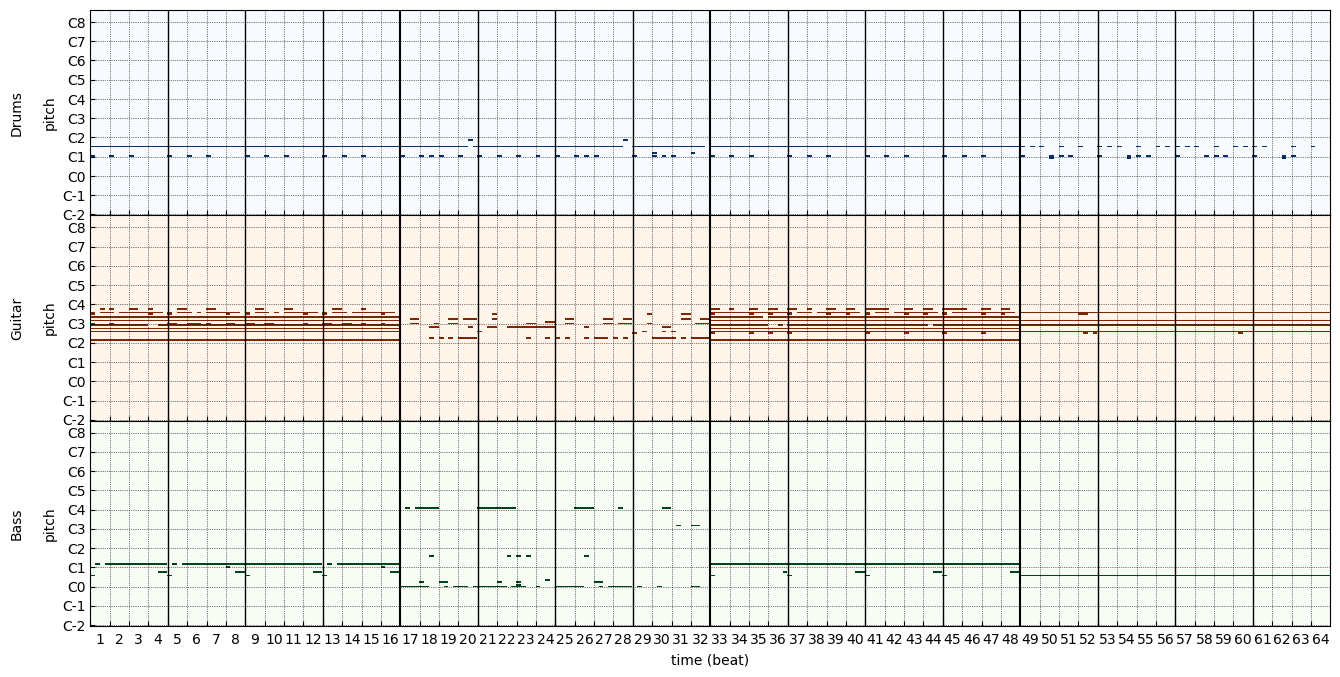

(asl= 0.8117, mf= 2.1877, kl_loss= 0.8573, kl_beta= 0.0314):  20%|███████▍                             | 3599/18000 [02:52<06:00, 39.93it/s]

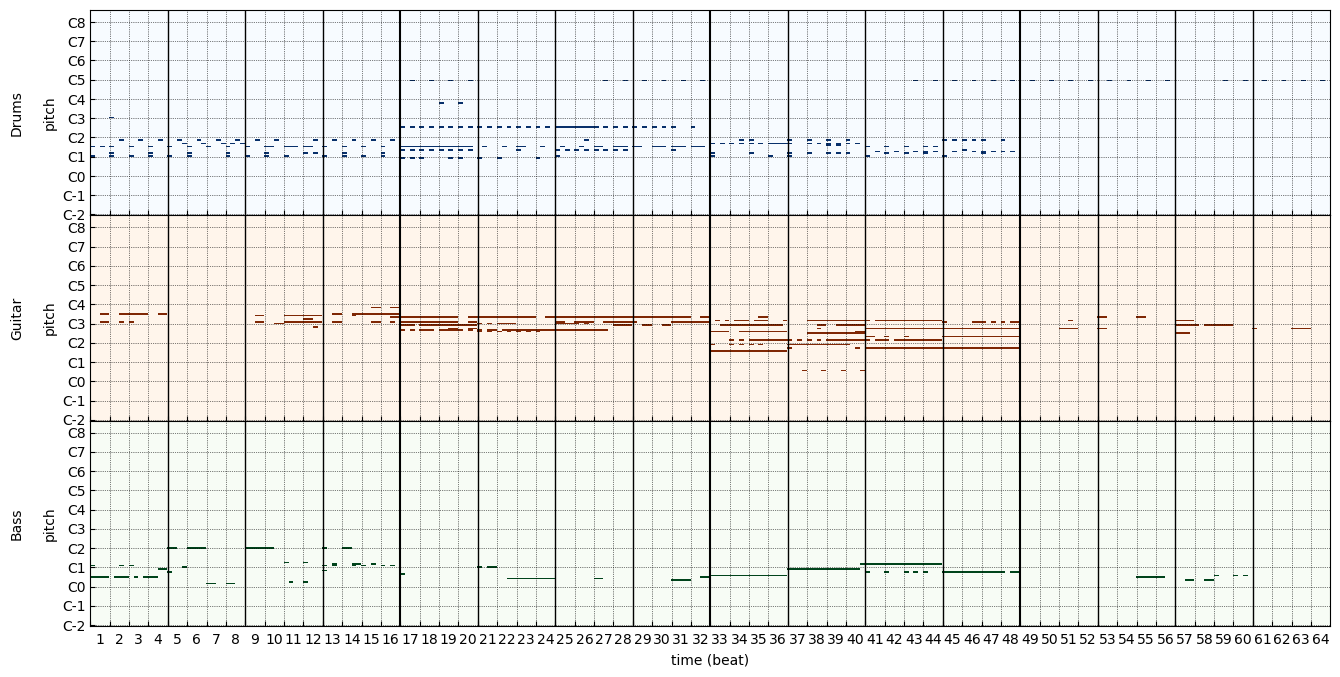

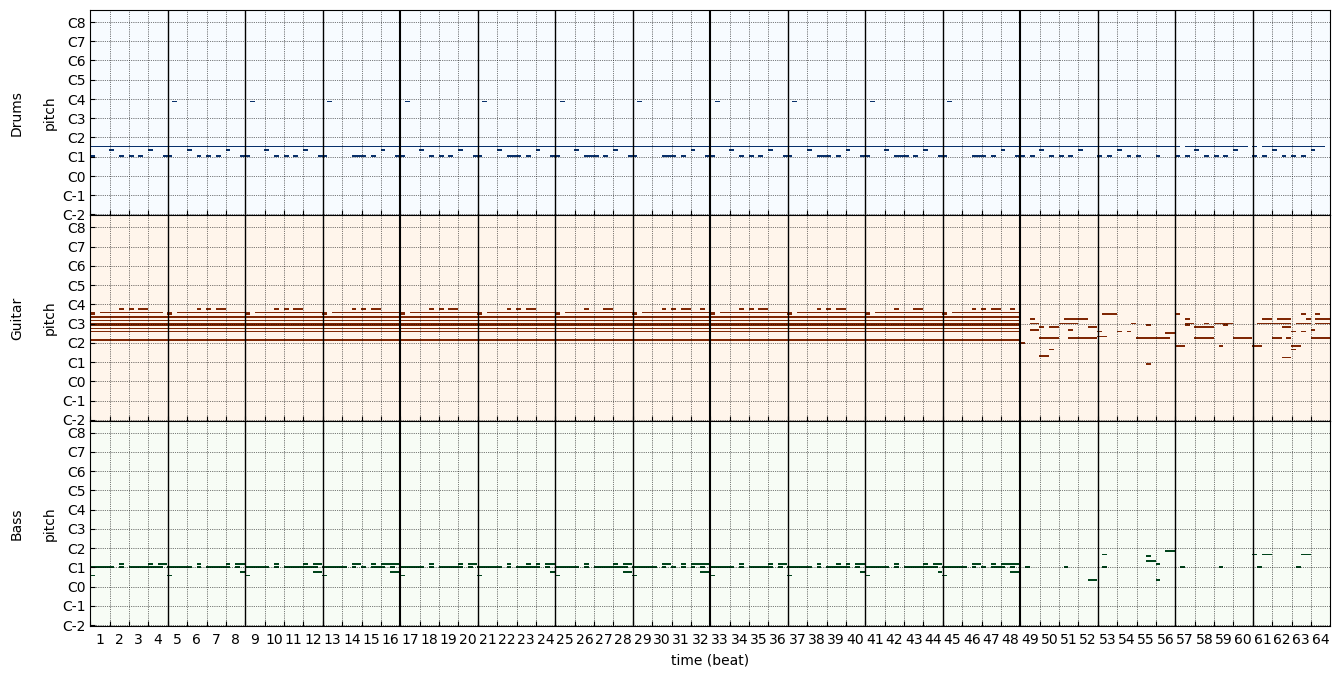

(asl= 0.8088, mf= 2.7448, kl_loss= 0.7426, kl_beta= 0.0878):  30%|███████████                          | 5399/18000 [04:12<04:36, 45.53it/s]

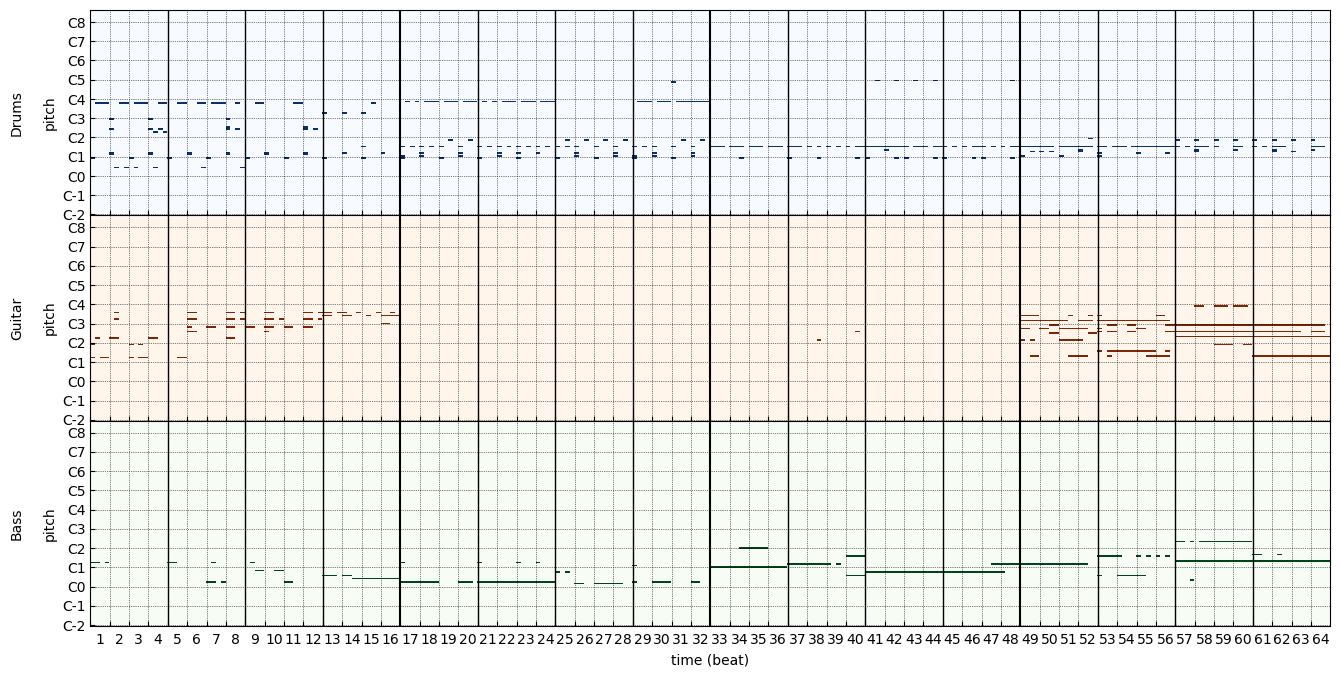

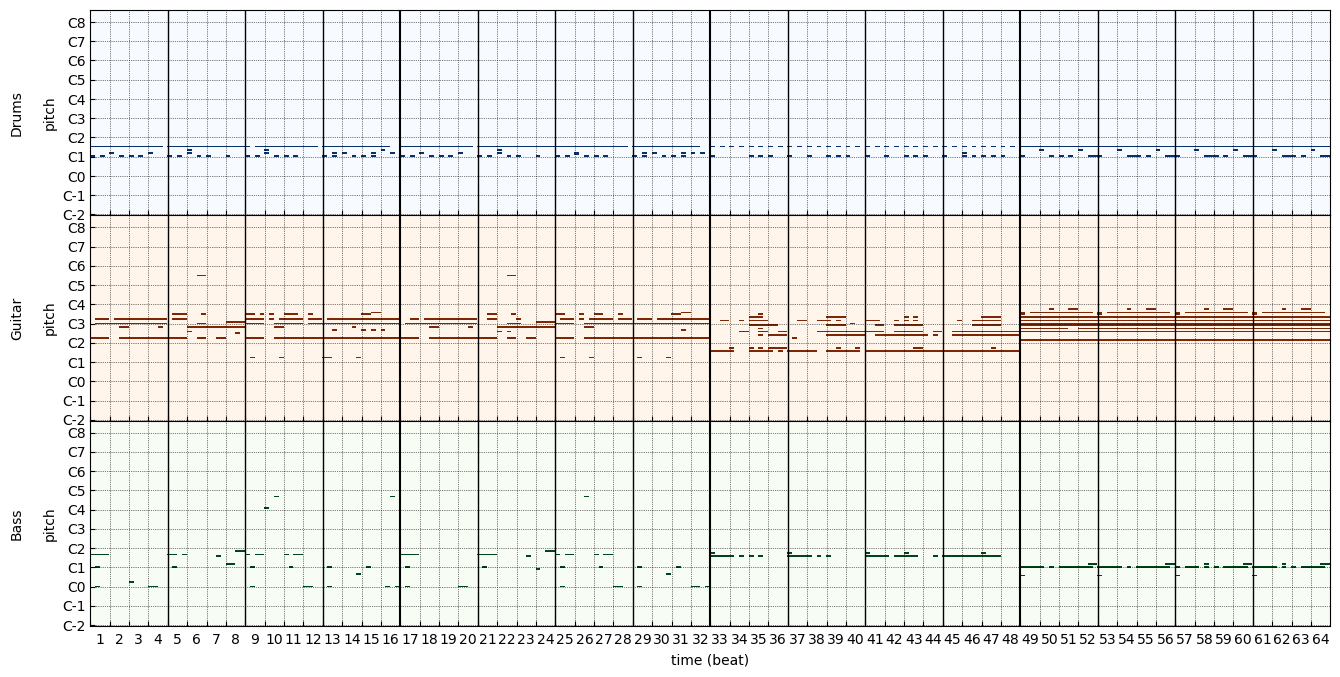

(asl= 0.8313, mf= 2.5660, kl_loss= 0.7868, kl_beta= 0.0208):  40%|██████████████▊                      | 7199/18000 [05:28<04:04, 44.10it/s]

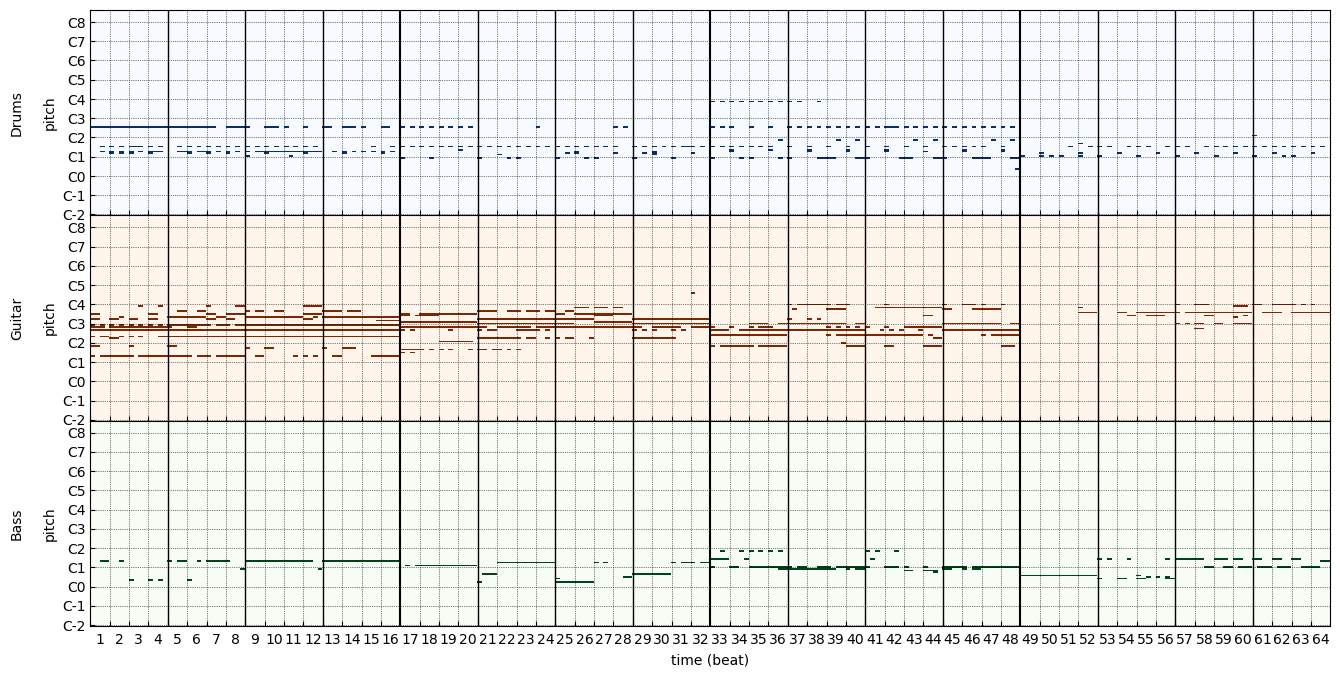

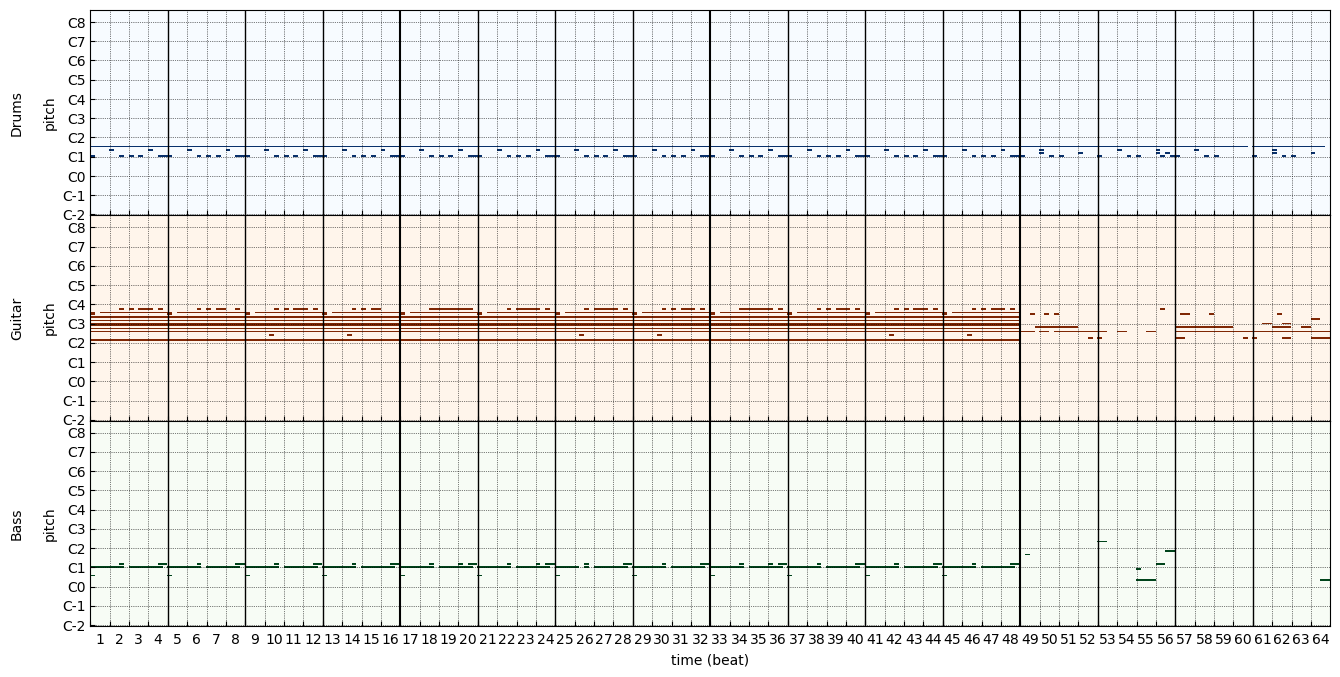

(asl= 0.7329, mf= 2.9525, kl_loss= 0.5487, kl_beta= 0.1555):  50%|██████████████████▍                  | 8999/18000 [06:45<03:25, 43.80it/s]

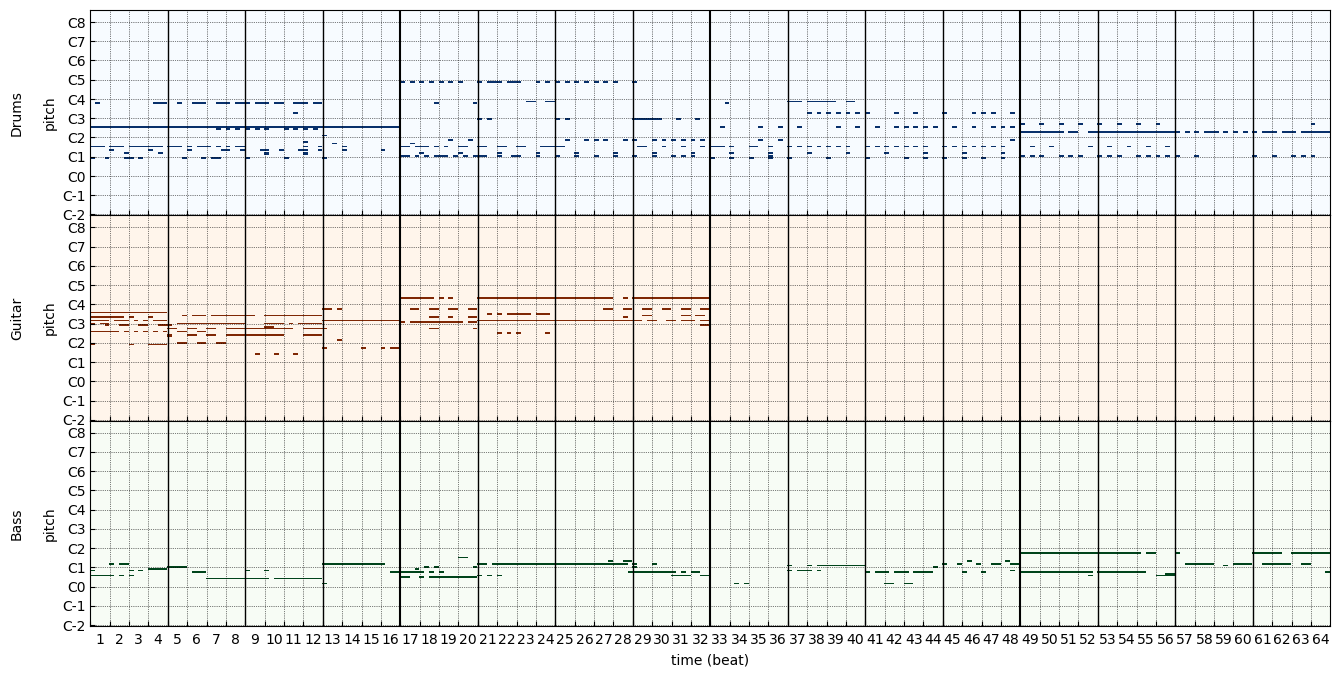

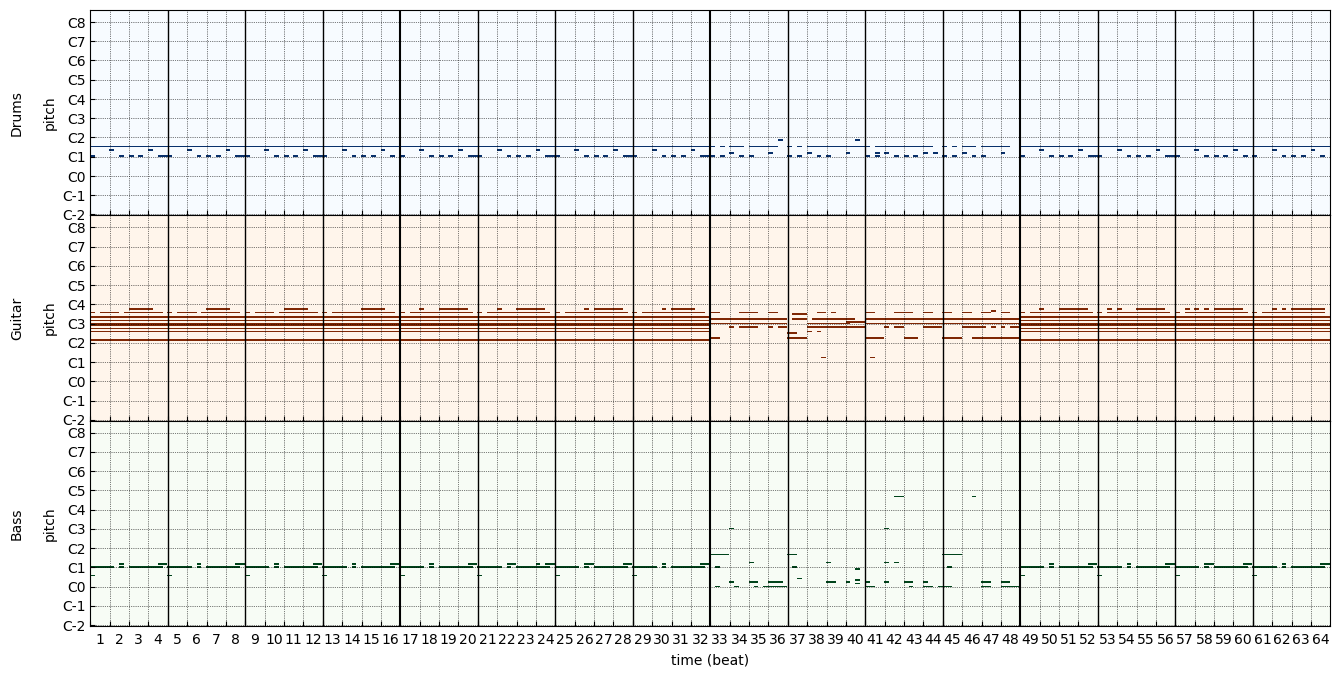

(asl= 0.7896, mf= 3.4698, kl_loss= 0.5490, kl_beta= 0.1556):  50%|██████████████████▌                  | 9000/18000 [06:46<03:25, 43.80it/s]

Unfreezing encoder


(asl= 0.7612, mf= 3.3439, kl_loss= 0.5131, kl_beta= 0.3411):  60%|█████████████████████▌              | 10800/18000 [08:11<03:04, 39.05it/s]

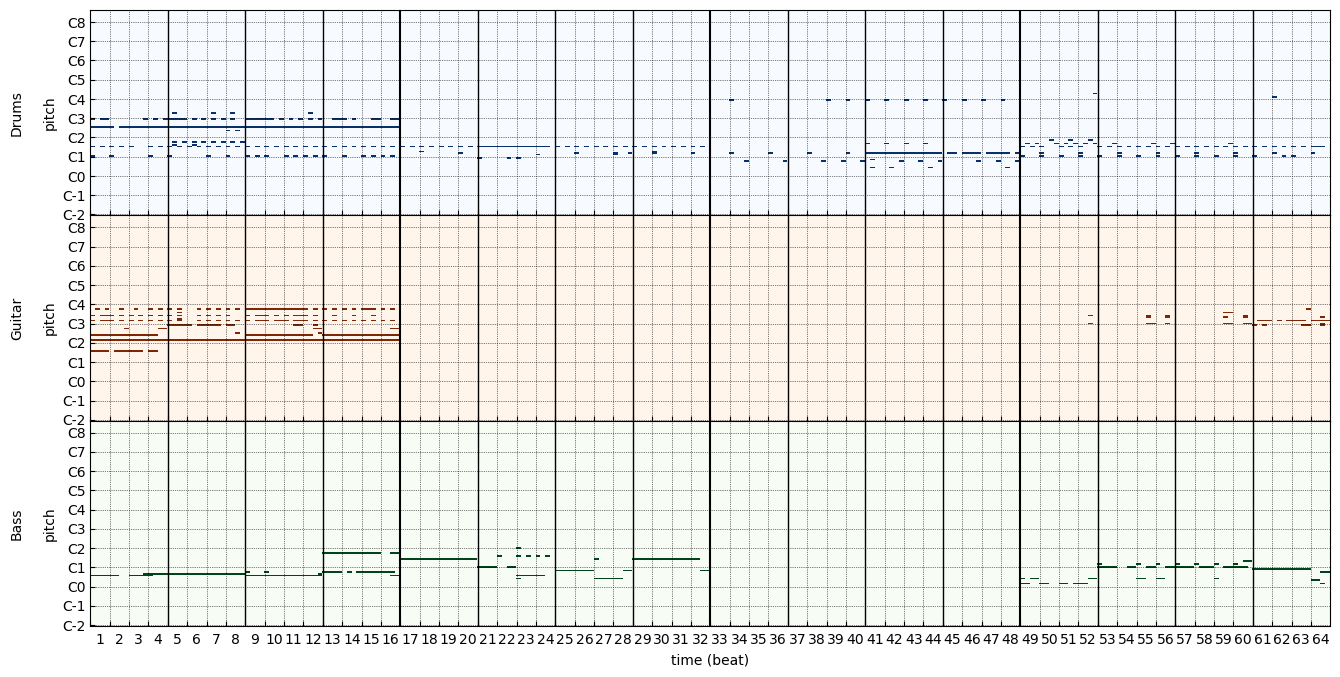

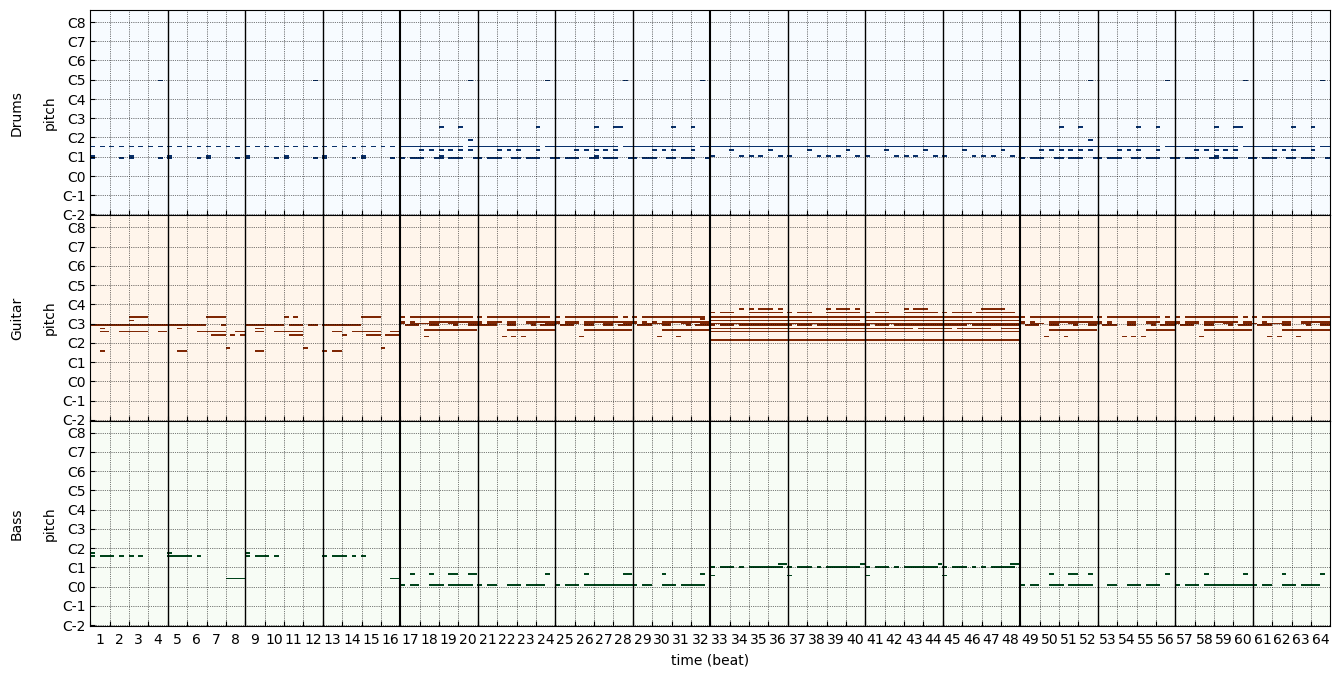

(asl= 0.7541, mf= 3.2408, kl_loss= 0.5523, kl_beta= 0.0308):  70%|█████████████████████████▏          | 12599/18000 [09:36<02:27, 36.65it/s]

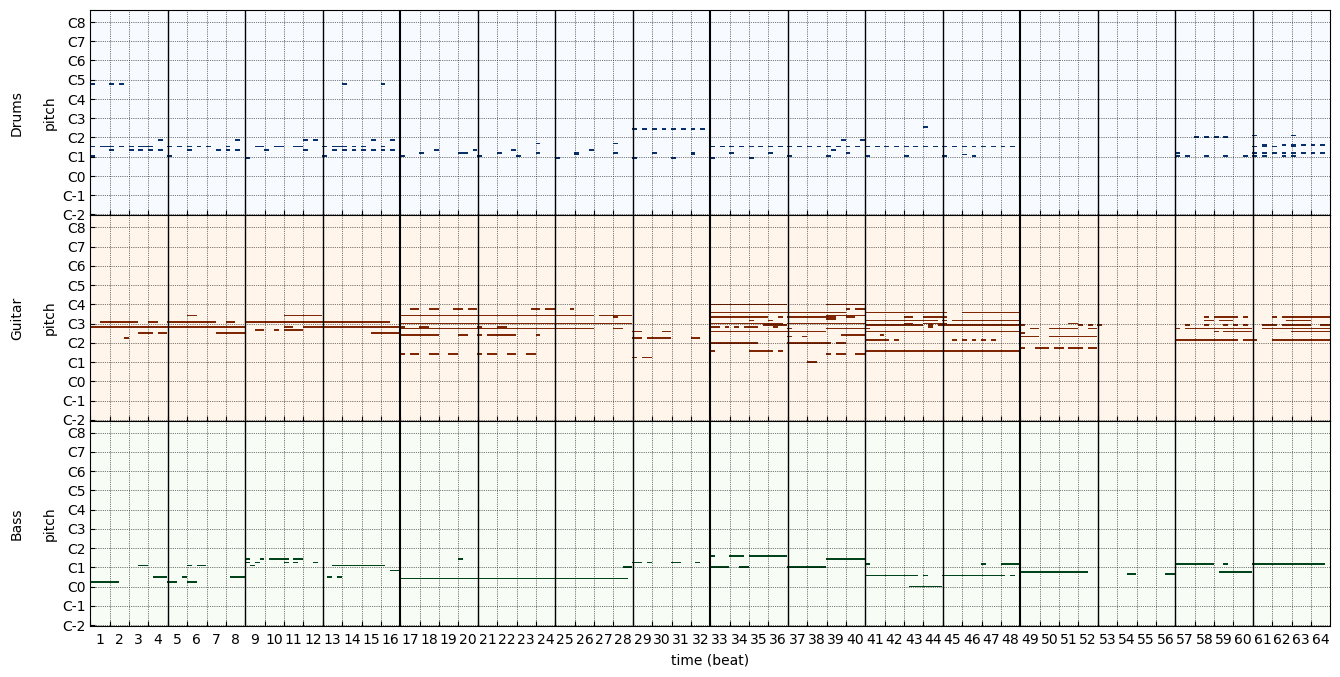

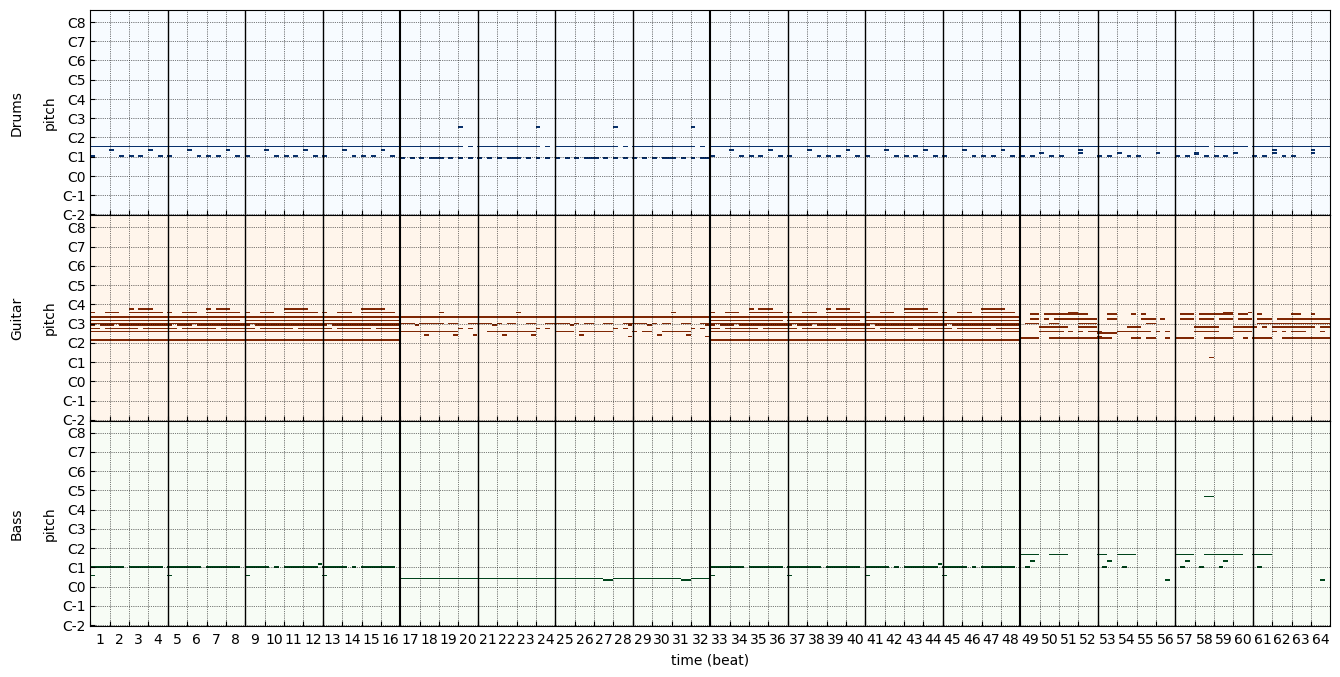

(asl= 0.7132, mf= 3.1517, kl_loss= 0.5065, kl_beta= 0.2721):  80%|████████████████████████████▊       | 14399/18000 [11:03<01:40, 35.82it/s]

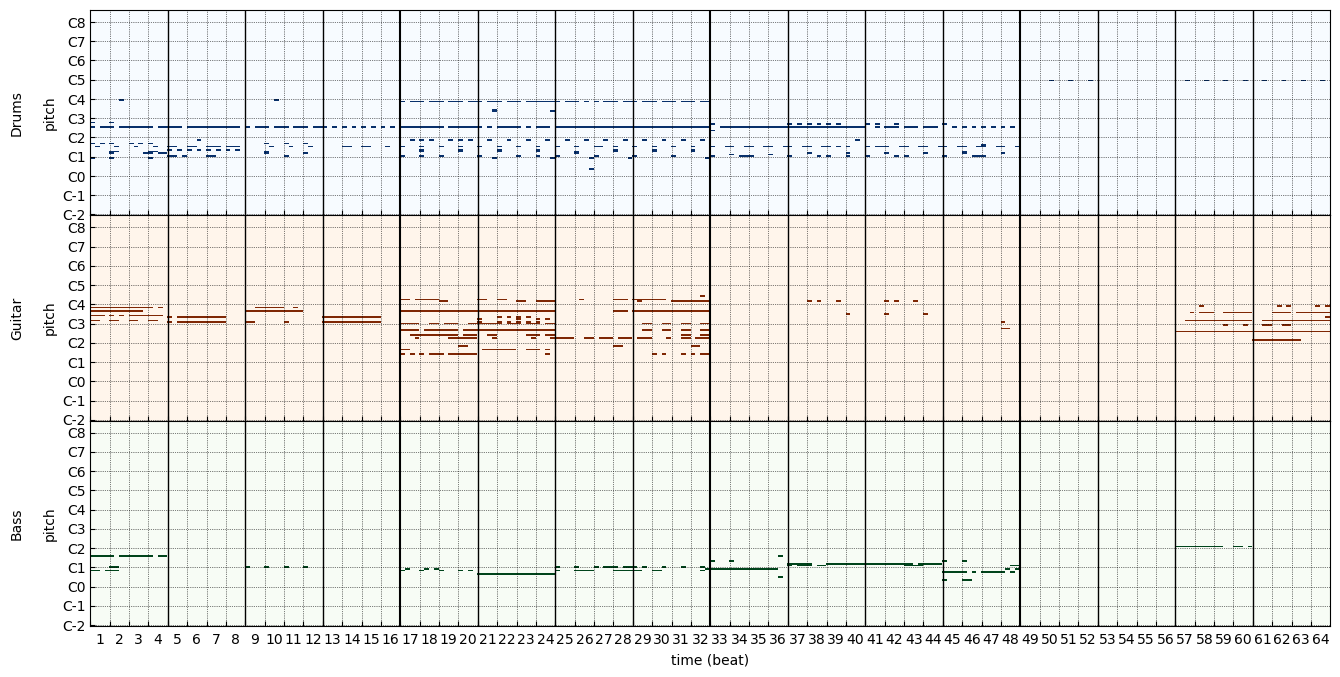

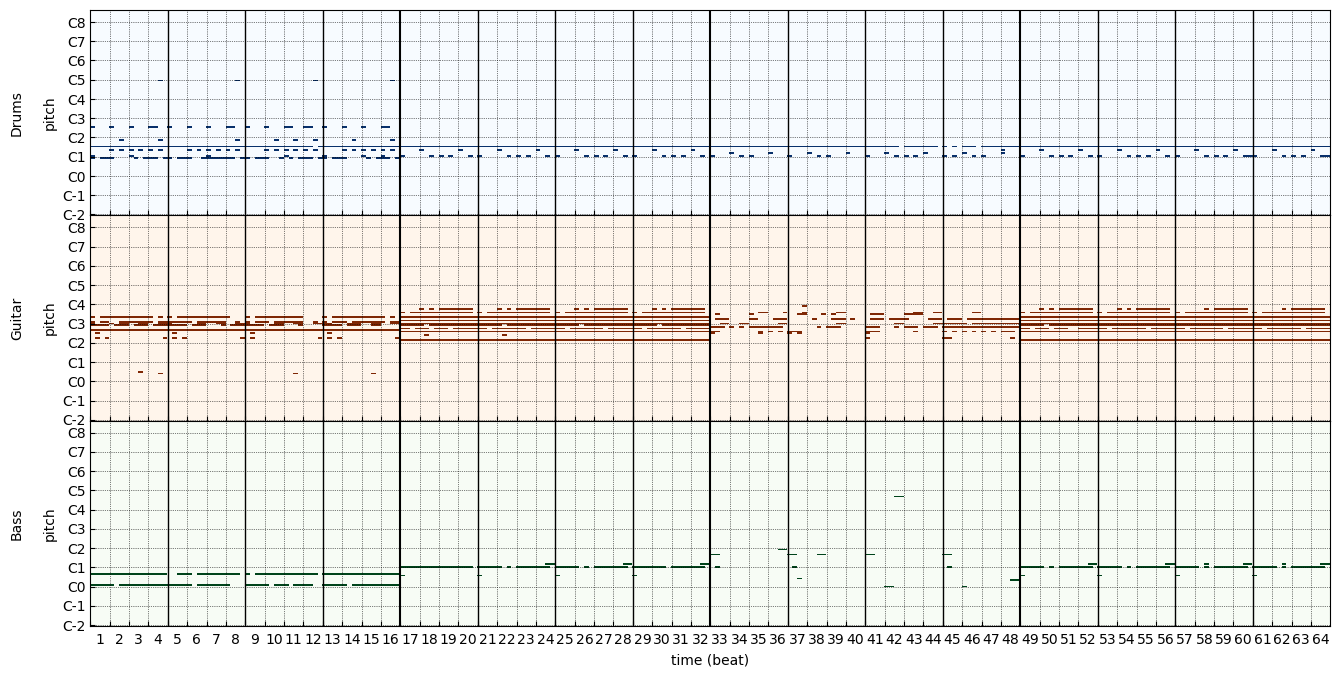

(asl= 0.6981, mf= 2.9489, kl_loss= 0.5014, kl_beta= 0.7214):  90%|████████████████████████████████▍   | 16199/18000 [12:32<00:51, 34.88it/s]

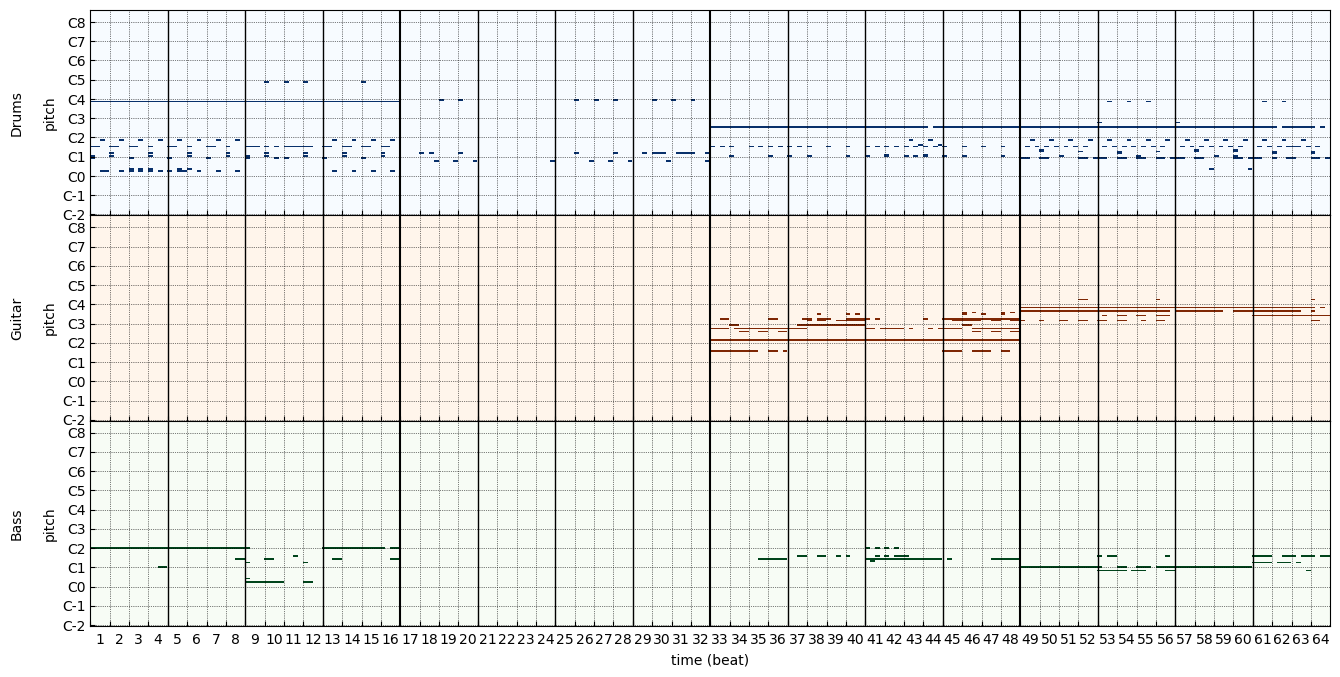

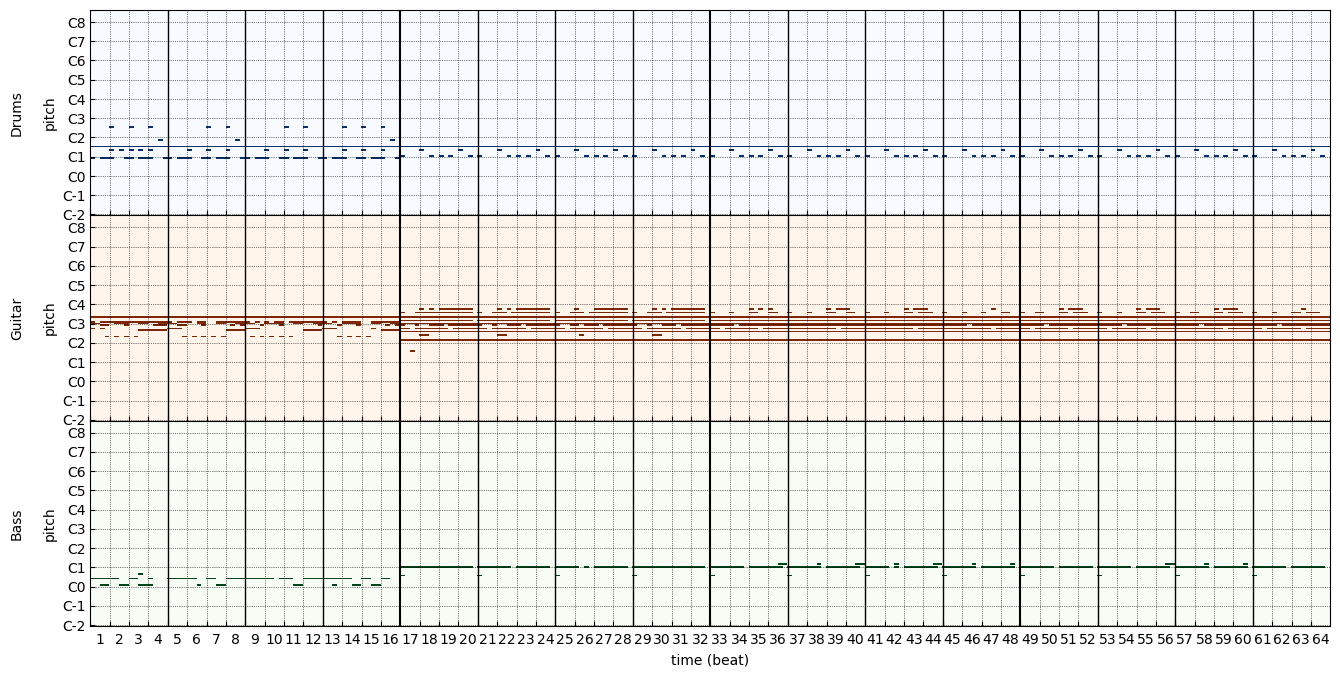

(asl= 0.8086, mf= 2.9863, kl_loss= 0.5044, kl_beta= 0.9889): 100%|███████████████████████████████████▉| 17999/18000 [14:08<00:00, 35.50it/s]

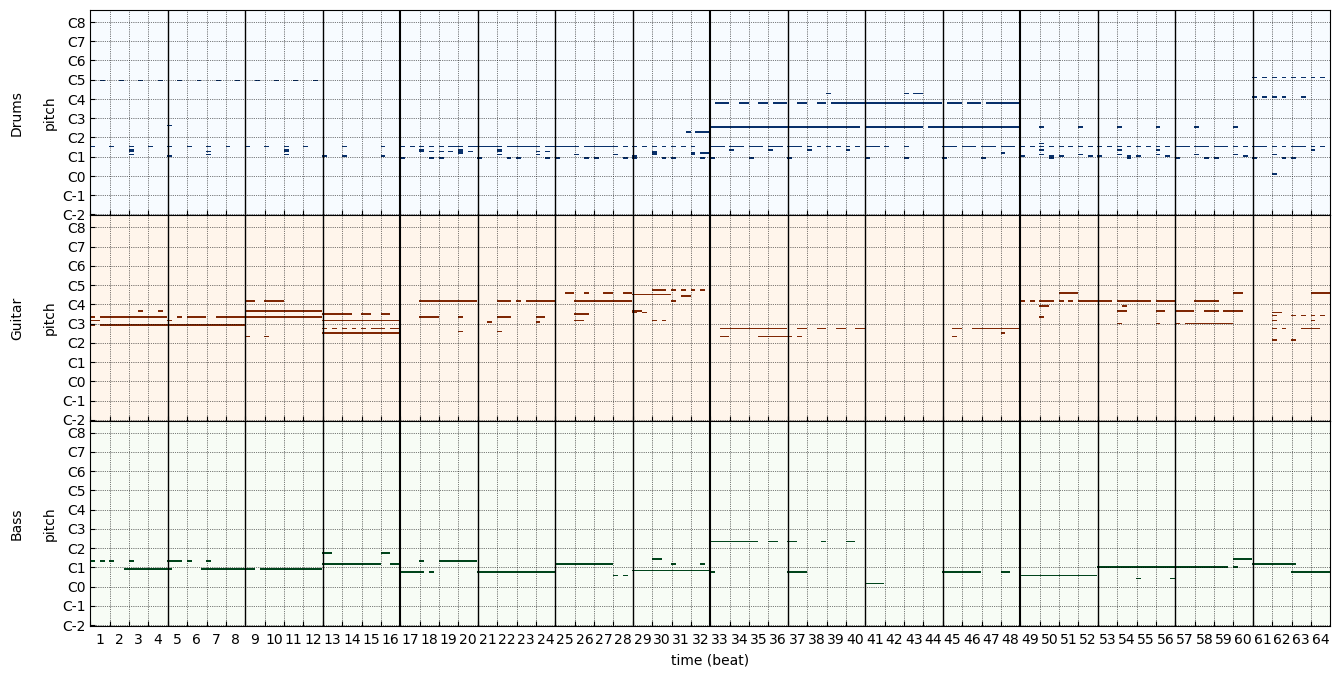

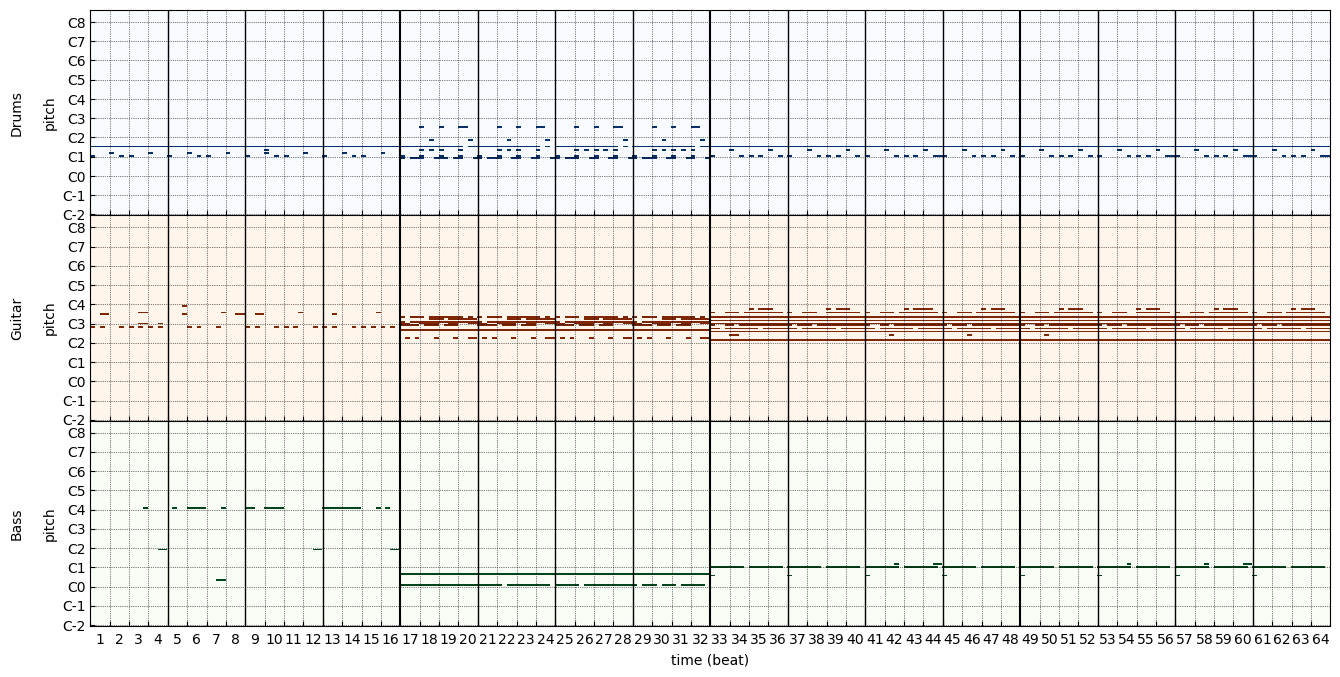

(asl= 0.8086, mf= 2.9863, kl_loss= 0.5044, kl_beta= 0.9889): 100%|████████████████████████████████████| 18000/18000 [14:24<00:00, 35.50it/s]

In [ ]:
# Create a progress bar instance for monitoring
steps_per_epoch = len(train_data_loader)
n_steps = n_epochs * steps_per_epoch
progress_bar = tqdm(total=n_steps, initial=step, ncols=140, position=0, leave=True)

# Initialize KL Divergence coefficient
kl_beta = 0.0
num_kl_cycles = 3
steps_per_cycle = int(steps_per_epoch*(n_epochs/num_kl_cycles))

# Prepare logging and saving steps
val_interval = steps_per_epoch//10
eval_steps = range(0,n_steps+1,val_interval)

# Freeze generator and decide how and when to unfreeze
autoencoder.freeze()
enc_unfreeze_epoch = n_epochs//2 # Set very high if you don't want to unfreeze

for name, param in autoencoder.dec.named_parameters():
    if param.requires_grad:
        print("Something wrong")

# Start iterations
while epoch < n_epochs:

    # Unfreeze the encoder if target epoch is reached
    if epoch==enc_unfreeze_epoch:
      autoencoder.unfreeze_enc()
      print("Unfreezing encoder")
      for name, param in autoencoder.enc.named_parameters():
        if not param.requires_grad:
            print("Something wrong")

    # Iterate over the dataset
    for x in train_data_loader:

        # In case the initial 'step' is not 0
        if step>n_steps:
            break

        # Compute the kl_beta coefficient for this step (Cyclical KL Annealing)
        # Every cycle KL divergence's weight drops.
        # Its impact raises through the first half of the cycle, then remains
        # up for another half. The maximum value raises every cycle
        # kl_beta = min((step%steps_per_cycle)/(steps_per_cycle//2),1.0)*np.sqrt(step/n_steps)
        kl_beta = torch.nn.functional.sigmoid(torch.tensor((step%steps_per_cycle)/(steps_per_cycle//8)-3.5))*((step/n_steps)**2)

        # Train the neural network
        autoencoder.train()
        asl_loss,mf_loss, kl_loss = train_one_step(a_optimizer, x, kl_beta)
        # Update loss to progress bar
        progress_bar.set_description_str(
          "(asl={: 6.4f}, mf={: 6.4f}, kl_loss={: 6.4f}, kl_beta={: 6.4f})".format(asl_loss,mf_loss,kl_loss,kl_beta))

        writer.add_scalar('ASL',asl_loss.item(),step)
        writer.add_scalar('MF',mf_loss.item(),step)
        writer.add_scalar('kl_div',kl_loss.item(),step)
        writer.add_scalar('kl_beta',kl_beta,step)

        if step in eval_steps:
            val_asl_loss = 0.0
            val_mf_loss = 0.0
            for x_eval in test_data_loader:
                d_samples = autoencoder(x_eval)
                val_asl_loss += assym_loss(d_samples,x_eval).item()
                val_mf_loss += compare_mf(d_samples,x_eval).item()

            val_asl_loss /= len(test_data_loader)
            val_mf_loss /= len(test_data_loader)

            writer.add_scalar('val_ASL',val_asl_loss,step)
            writer.add_scalar('val_MF',mf_loss,step)

        step += 1
        progress_bar.update(1)

    epoch += 1

    # Save the checkpoint
    save_checkpoint(checkpoint_path,mf_loss)

    autoencoder.eval()

    with torch.no_grad():

        # Plot an example of autoencoding
        samples = data[np.random.randint(0,len(data),4)]
        plot_multitrack(samples_to_multitrack(samples.cpu().detach().numpy()))
        if torch.cuda.is_available():
            samples = samples.cuda()
        autoencoded_sample = autoencoder(samples)
        plot_multitrack(samples_to_multitrack(clip_samples(autoencoded_sample,note_thresholds).cpu().detach().numpy()))

In [ ]:
writer.flush()
progress_bar.close()

(ssim= 0.3376, asl= 0.8527, mae= 0.0342, mf= 0.7114, kl_loss= 0.6934, kl_beta= 0.9890): 100%|█████████| 18000/18000 [29:06<00:00, 10.31it/s]


In [ ]:
# Save final model
torch.save({
    'epoch':step,
    'model_state_dict':autoencoder.state_dict(),
    'optimizer_state_dict':a_optimizer.state_dict(),
    'loss':mf_loss
},checkpoint_path)

# Inference


In [ ]:
#@title Recover best model

# Import the state dictionaries
if torch.cuda.is_available():
  device = torch.device('cuda')
  checkpoint = torch.load(checkpoint_path)
else:
  device = torch.device('cpu')
  checkpoint = torch.load(checkpoint_path, map_location=device)

autoencoder.load_state_dict(checkpoint['model_state_dict'])
a_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
#@title Recover last training step

# Import the state dictionaries
if torch.cuda.is_available():
  device = torch.device('cuda')
  checkpoint = torch.load(checkpoint_path)
else:
  device = torch.device('cpu')
  checkpoint = torch.load(checkpoint_path, map_location=device)

autoencoder.load_state_dict(checkpoint['model_state_dict'])
a_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## Latent space exploration



In [ ]:
after_enc = np.zeros((1,128))
pre_dec = np.zeros((1,128))

with torch.no_grad():
  for x in train_data_loader:

    if torch.cuda.is_available():
      x = x.cuda()

    z = autoencoder.get_encoding(x)
    after_enc = np.append(after_enc,z.cpu().detach().numpy(),axis=0)
    z = autoencoder.sample_latent_space(z)
    pre_dec = np.append(pre_dec,z.cpu().detach().numpy(),axis=0)


after_enc = after_enc[1:]
print(after_enc.shape)
pre_dec = pre_dec[1:]
print(pre_dec.shape)

(51312, 128)
(51312, 128)


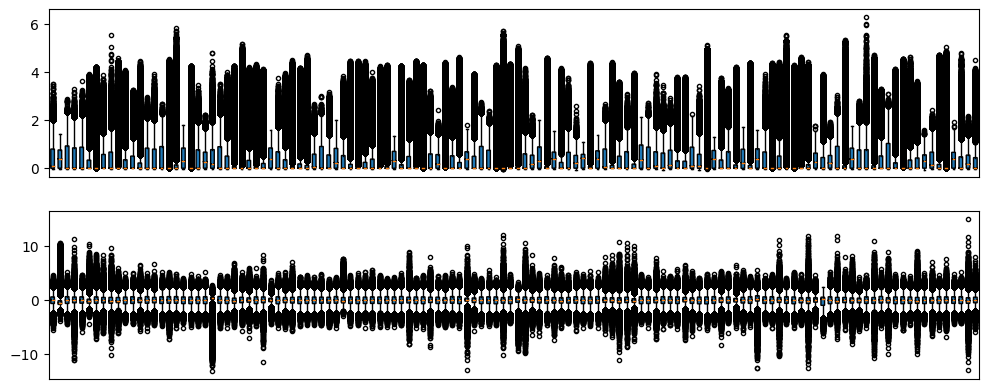

In [ ]:
# Plot of the distribution of the latent space
# (Violin plots would be better suited, but there are too many dimensions
# for matplotlib to plot it like anything other than a blue line)

fig, ax = plt.subplots(2,1)
fig.set_figwidth(12)
ax[0].get_xaxis().set_visible(False)
bp = ax[0].boxplot(after_enc, patch_artist = True, notch='True')
for flier in bp['fliers']:
    flier.set(marker ='.')
ax[1].get_xaxis().set_visible(False)
bp = ax[1].boxplot(pre_dec, patch_artist = True, notch='True')
for flier in bp['fliers']:
    flier.set(marker ='.')